# emcee and Bayesian Software Tools

## Review of emcee

In [1]:
import emcee
import numpy as np
import matplotlib.pyplot as plt

In [2]:
c_true = (5, 0.12, 11/4)
N = 50
x = np.sort(10*np.random.rand(N))
yerr = 1 + 5 * np.random.rand(N)
y = c_true[0] + c_true[1]*x + c_true[2]*x**2
y += yerr * np.random.randn(N)

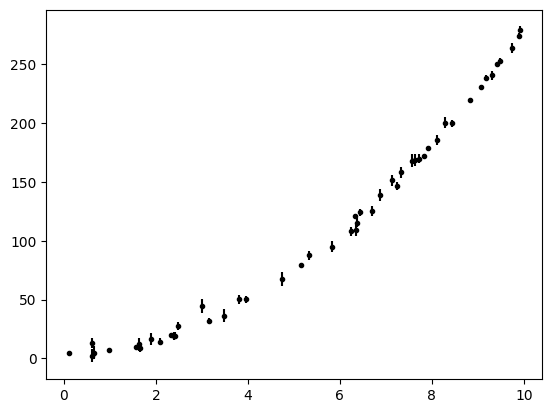

In [3]:
plt.errorbar(x, y, yerr=yerr, fmt="k.");

In [4]:
def log_likelihood(theta, x, y, yerr):
    theory = theta[0] + theta[1] * x + theta[2] * x**2
    return -0.5 * np.sum((y-theory) **2 / yerr**2 + np.log(yerr))

def log_prior(theta):
    if -10 < theta[0] < 10 and -10 < theta[1] < 10 and -10 < theta[2] < 10:
       return 0.0
    return - np.inf

def log_prob(theta, x, y, err):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [5]:
nwalkers, ndim = 32, 3
pos = [0, 0, 0] + 1e-3 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(x, y, yerr))
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2749.87it/s]


## Arviz: Exploratory analysis of Bayesian models

https://python.arviz.org/en/latest/index.html

In [6]:
import arviz as az

In [7]:
idata = az.from_emcee(sampler, var_names=["c0", "c1", "c2"])

In [8]:
idata

Inference data with groups:
        > posterior
        > sample_stats
        > observed_data

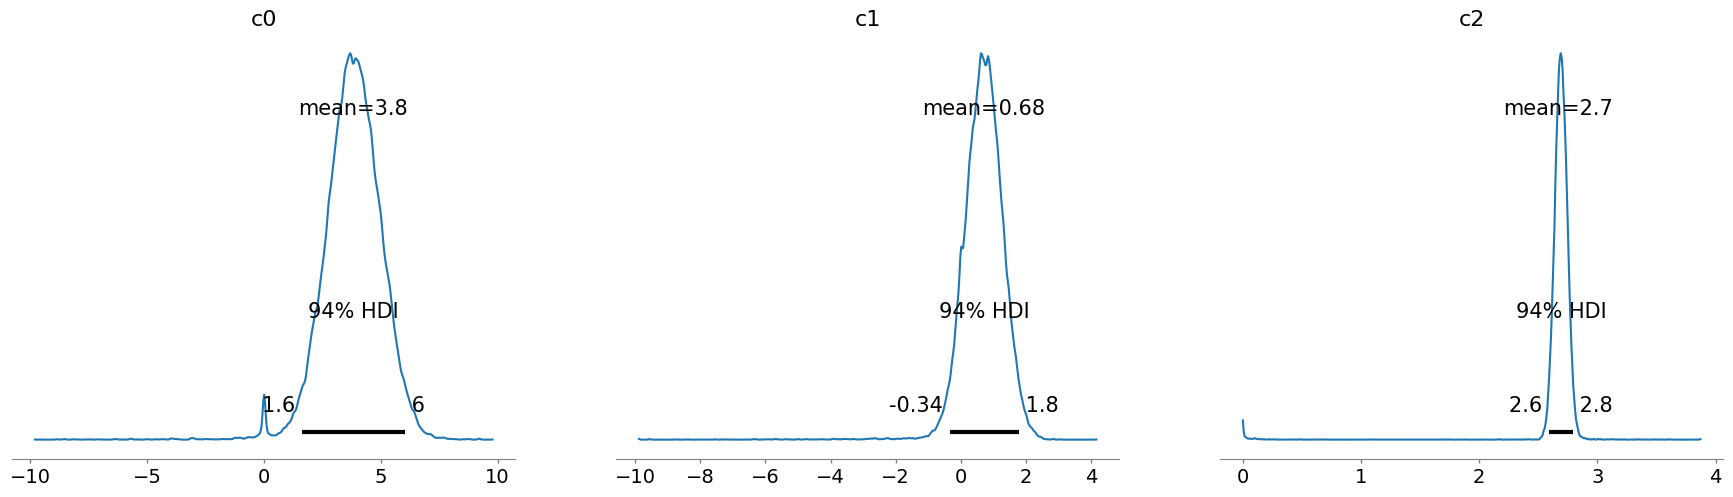

In [9]:
az.plot_posterior(idata, var_names=["c0", "c1", "c2"]);

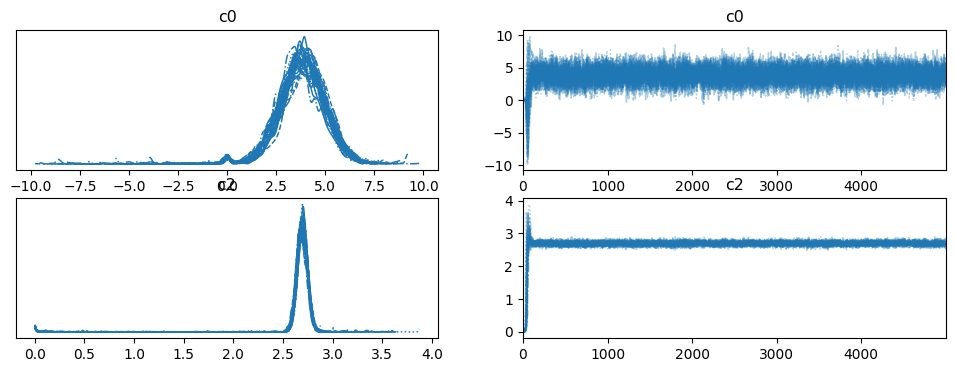

In [10]:
az.plot_trace(idata, var_names=("c0", "c2"));

## blobs: unlock sample stats, posterior predictive and miscellanea

We will see how to do this first with `emcee`, but define these terms with `pymce`.

In [11]:
def log_prob_blobs(theta, x, y, err):
    lp = log_prior(theta)
    like_vector = log_likelihood(theta, x, y, yerr)
    like = np.sum(like_vector)
    return lp + like, like_vector

In [12]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_blobs, args=(x, y, yerr))
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:02<00:00, 2238.72it/s]


In [13]:
idata = az.from_emcee(
    sampler,
    var_names=["c0", "c1", "c2"],
    blob_names=["log_likelihood"],
)
idata

Inference data with groups:
        > posterior
        > log_likelihood
        > sample_stats
        > observed_data

## PyMC

Note, you need python 3.11 and not newer!

Instalation - https://www.pymc.io/projects/docs/en/latest/installation.html
Simple linear regression - https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/GLM_linear.html#glm-linear

In [14]:
import pymc as pm

In [15]:
# model is y = c0 + c1*x + c2*x^2 + noise

# build a model via a `with` context block.
with pm.Model() as model:
    # define priors on polynomial coeffiencts and the added noise
    c0 = pm.Normal('c0', 0, 20)
    c1 = pm.Normal('c1', 0, 20)
    c2 = pm.Normal('c2', 0, 20)
    noise = pm.Exponential('noise', 0.1) #could be half-Normal or half-chauchy

    # define observations: y = c0 + c1*x + c2*x^2
    # link variables to data with `observed=y`
    obs = pm.Normal('obs', c0 + c1*x + c2*x**2, noise, observed=y)

    # run sampler
    idata = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c0, c1, c2, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


Inference data with groups:
        > posterior
        > sample_stats
        > observed_data

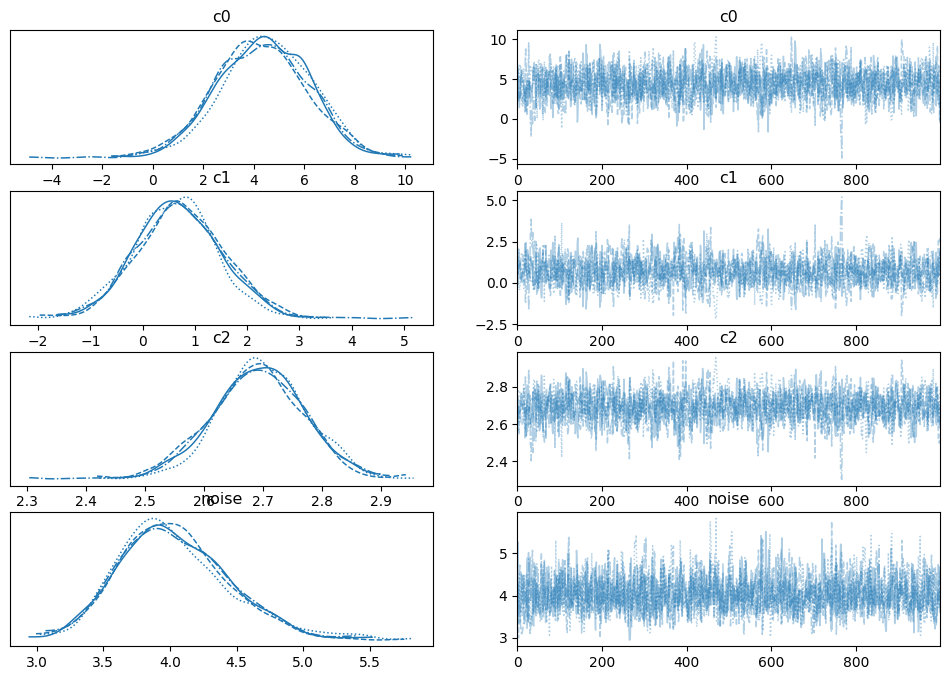

In [16]:
az.plot_trace(idata)
idata

You might need to install Graphviz, https://graphviz.org/download/

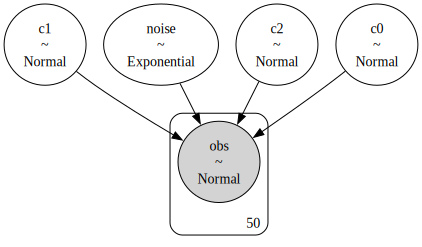

In [17]:
pm.model_to_graphviz(model)

In [18]:
with model:
    idata.extend(pm.sample_prior_predictive())
    idata.extend(pm.sample_posterior_predictive(idata))

Sampling: [c0, c1, c2, noise, obs]
Sampling: [obs]


Output()

In [19]:
idata

Inference data with groups:
        > posterior
        > posterior_predictive
        > sample_stats
        > prior
        > prior_predictive
        > observed_data

<Axes: xlabel='obs'>

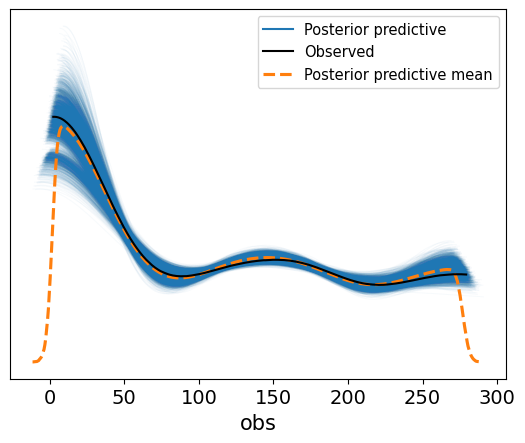

In [20]:
az.plot_ppc(idata, alpha=0.03, textsize=14)

<Axes: xlabel='obs'>

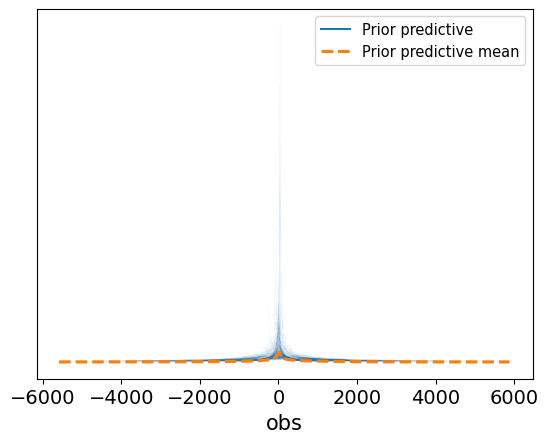

In [21]:
az.plot_ppc(idata, alpha=0.03, textsize=14, group="prior")

## Further Reading

* Inference Data - https://python.arviz.org/en/latest/getting_started/XarrayforArviZ.html
*  PyMC basics - https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html
*  Simple linear regression - https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/GLM_linear.html#glm-linear

In [22]:
%load_ext watermark
%watermark -untzvm -iv -w

Last updated: Thu Apr 17 2025 11:36:34CDT

Python implementation: CPython
Python version       : 3.11.12
IPython version      : 9.1.0

Compiler    : Clang 18.1.8 
OS          : Darwin
Release     : 24.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 12
Architecture: 64bit

arviz     : 0.21.0
pandas    : 2.2.3
matplotlib: 3.10.1
rich      : 14.0.0
numpy     : 1.25.2
emcee     : 3.1.6
pymc      : 5.22.0

Watermark: 2.5.0

